<a href="https://colab.research.google.com/github/uc-bd2k/ilincsAPI/blob/master/usingIlincsApis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# iLINCS API R Notebook

## Prerequisites

In [ ]:
library(IRdisplay)
library(tinytex)
library(httr)
library(jsonlite)
library(htmltools)

if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("Biobase")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.2 (2021-11-01)

Installing package(s) 'BiocVersion', 'Biobase'

also installing the dependency ‘BiocGenerics’


Old packages: 'pbdZMQ', 'brew', 'generics', 'pillar', 'readr', 'rlang',
  'svglite', 'tidyr'



## Display Signature Libraries

In [ ]:
apiUrl <- "http://www.ilincs.org/api/SignatureLibraries"
req <- GET(apiUrl)
json <- httr::content(req, as = "text")
ilincs_libraries <- fromJSON(json)
ilincs_libraries[,c("libraryID","libraryName")]

,libraryID,libraryName
,<chr>,<chr>
1,LIB_1,Disease related signatures
2,LIB_10,Cancer therapeutics response signatures
3,LIB_11,LINCS gene overexpression signatures
4,LIB_12,DrugMatrix signatures
5,LIB_13,Transcriptional signatures from EBI Expression Atlas
6,LIB_14,Pharmacogenomics transcriptional signatures
7,LIB_2,Connectivity Map signatures
8,LIB_3,ENCODE transcription factor binding signatures
9,LIB_5,LINCS chemical perturbagen signatures


## Searching for signature using BROAD ID

##### Searching for signature for given term. In this example **"Diclofenac"** coumpound will be shown as an example.

In [ ]:
term <- "Diclofenac"
ilincs_libId<-"LIB_5"
apiUrl <- paste("http://www.ilincs.org/api/SignatureMeta/findTermWithSynonyms?term=",term,"&library=",ilincs_libId,sep="")
req <- GET(apiUrl)

ilincs_result_df<-fromJSON(httr::content(req,type="text"))$data
head(ilincs_result_df[,c("cellline","compound","concentration","signatureid","is_exemplar")])

No encoding supplied: defaulting to UTF-8.



,cellline,compound,concentration,signatureid,is_exemplar
,<chr>,<chr>,<chr>,<chr>,<int>
1,A375,Diclofenac,10uM,LINCSCP_100,1
2,MCF7,Diclofenac,0.04uM,LINCSCP_135985,NA
3,HA1E,Diclofenac,10uM,LINCSCP_14684,0
4,PC3,Diclofenac,10uM,LINCSCP_154188,NA
5,PC3,Diclofenac,3.33uM,LINCSCP_154189,NA
6,A375,Diclofenac,10uM,LINCSCP_178714,0


### Selecting a signature to analyze

In [ ]:
ilincs_signatureId <- ilincs_result_df[1,"signatureid"]
ilincs_signatureId

[1] "LINCSCP_100"

## Getting signature data and vulcano plot

##### The first step is to retrieve the session id for creation of the signature data table

In [ ]:
req <- POST("http://www.ilincs.org/api/ilincsR/downloadSignature", body = list(sigID = paste(ilincs_signatureId), display = FALSE), encode = "json")
ilincs_sessionId<-unlist(httr::content(req))
ilincs_sessionId

data 
"sig_Sat_Feb__5_06_06_07_2022_3362179"

### Retrieving data

In [ ]:
fileUrl<-paste("http://www.ilincs.org/tmp/",ilincs_sessionId,".xls",sep="")
signatureData<-read.table(fileUrl,sep="\t",header=T,stringsAsFactors = F)
head(signatureData)

,signatureID,PROBE,ID_geneid,Name_GeneSymbol,Value_LogDiffExp,Significance_pvalue
,<chr>,<lgl>,<int>,<chr>,<dbl>,<dbl>
1,LINCSCP_100,NA,16,AARS,1.047000,0.200843394
2,LINCSCP_100,NA,23,ABCF1,0.787095,0.083514594
3,LINCSCP_100,NA,25,ABL1,-2.933770,0.004530523
4,LINCSCP_100,NA,30,ACAA1,2.821140,0.001994390
5,LINCSCP_100,NA,39,ACAT2,0.528219,0.183911294
6,LINCSCP_100,NA,47,ACLY,2.308770,0.049860369


### Insert volcano plot

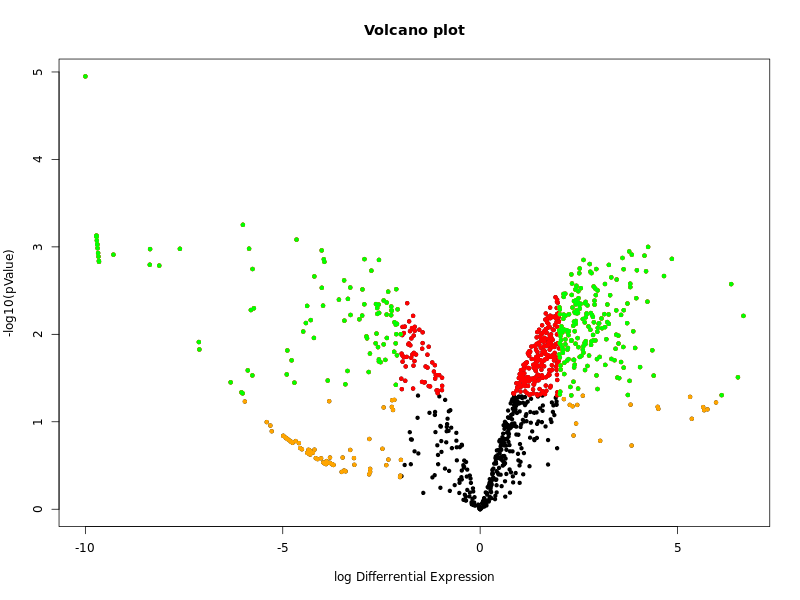

In [ ]:
apiUrl <- paste("http://www.ilincs.org/api/ilincsR/volcanoPlot?file=",ilincs_sessionId,".xls",sep="")
req <- GET(apiUrl)
ilincs_volcanoUrl<-paste("http://www.ilincs.org",httr::content(req)$url,sep="")
# include_graphics(ilincs_volcanoUrl)
display_png(file = url(ilincs_volcanoUrl,"rb"), width = 600, height = 300)

## Get connected signatures

In [ ]:
apiUrl <- paste("http://www.ilincs.org/api/SignatureMeta/findConcordantSignatures?sigID=",ilincs_signatureId,"&lib=",ilincs_libId,sep="")
req <- GET(apiUrl)
# prettify(httr::content(req,type="text"))
ilincs_conn_df<-fromJSON(httr::content(req,type="text"))
head(ilincs_conn_df)

No encoding supplied: defaulting to UTF-8.



,signatureid,similarity,significance,pValue,nGenes,factor,compound,concentration,cellline,tissue,treatment,time,lincspertid,stitchID,perturbagenID,pubChemID,lincsSigID,is_exemplar,GeneTargets
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
1,LINCSCP_176750,0.441378,317.264,5.444549e-318,978,NA,CHEMBL1208118,10uM,A375,skin,CHEMBL1208118,6h,LSM-3598,CID25124826,BRD-K71266197,25124826,CPC004_A375_6H:BRD-K71266197-236-01-9:10,1,ENTPD3
2,LINCSCP_124,0.439186,317.264,5.444549e-318,978,NA,Erythromycin Estolate,10uM,A375,skin,Erythromycin Estolate,6h,LSM-2876,CID71277,BRD-K39746403,71277,CPC004_A375_6H:BRD-K39746403-084-03-1:10,1,ABCB1|ALB|CYP3A4|CYP51A1|KCNH2|MLNR|SLC47A1
3,LINCSCP_65,0.434709,317.264,5.444549e-318,978,NA,Chlorthalidone,10uM,A375,skin,Chlorthalidone,6h,LSM-1417,CID2732,BRD-A26384407,2732,CPC004_A375_6H:BRD-A26384407-001-15-2:10,1,CA7|SLC12A3
4,LINCSCP_176580,0.424631,317.264,5.444549e-318,978,NA,Amidate,10uM,A375,skin,Amidate,6h,LSM-1640,CID36339,BRD-A54880345,36339,CPC004_A375_6H:BRD-A54880345-001-11-8:10,1,GABRA1|GABRA2|GABRA3|GABRA4|GABRA5|GABRA6|GABRB1|GABRB2|GABRB3|GABRD|GABRE|GABRG1|GABRG2|GABRG3|GABRP|GABRQ
5,LINCSCP_176625,0.423807,317.264,5.444549e-318,978,NA,Piperidolate,10uM,A375,skin,Piperidolate,6h,LSM-1951,CID4839,BRD-A97479839,4839,CPC004_A375_6H:BRD-A97479839-003-08-3:10,1,CHRM1
6,LINCSCP_176698,0.409430,317.264,5.444549e-318,978,NA,TOCRIS-0930,10uM,A375,skin,TOCRIS-0930,6h,LSM-2999,CID6604780,BRD-K45296539,6604780,CPC004_A375_6H:BRD-K45296539-003-01-0:10,0,ADRB3


## Find LINCS signatures connected to user a submitted signature

##### Creating user submitted signature in the form of a gene list

In [ ]:
# top100signature <- signatureData[order(signatureData$Significance_pvalue)[1:100],c("Name_GeneSymbol","Value_LogDiffExp","Significance_pvalue")]
top100signature <- signatureData[order(signatureData$Significance_pvalue)[1:100],]
head(top100signature)

,signatureID,PROBE,ID_geneid,Name_GeneSymbol,Value_LogDiffExp,Significance_pvalue
,<chr>,<lgl>,<int>,<chr>,<dbl>,<dbl>
379,LINCSCP_100,NA,5993,RFX5,-10.00000,1.122981e-05
539,LINCSCP_100,NA,9134,CCNE2,-6.00931,5.594009e-04
639,LINCSCP_100,NA,10434,LYPLA1,-9.71956,7.459595e-04
831,LINCSCP_100,NA,51056,LAP3,-9.71950,7.464972e-04
889,LINCSCP_100,NA,55748,CNDP2,-9.71718,7.666483e-04
939,LINCSCP_100,NA,79187,FSD1,-4.65059,8.272043e-04


### Uploading signature as a list genes for enrichment

In [ ]:
apiUrl <- "http://www.ilincs.org/api/ilincsR/findConcordancesSC"
req <- POST(apiUrl, body = list(mode="geneList",metadata=TRUE,signatureProfile = list(genes=top100signature$Name_GeneSymbol)),encode = "json")
ilincsEnrichedSignatures <- data.table::rbindlist(httr::content(req)$sigScores, use.names = TRUE, fill = TRUE)
head(ilincsEnrichedSignatures)

tableNames,zScores,compound,perturbagenID,ProteinTargets,concentration,cellLine,time
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
LINCSCP_100,17.3629,Diclofenac,LSM-2160,PTGS1|PTGS2,10uM,A375,6h
LINCSCP_65,7.4109,Chlorthalidone,LSM-1417,CA7|SLC12A3,10uM,A375,6h
LINCSCP_109,7.3279,RS-39604,LSM-2461,HTR4,10uM,A375,6h
LINCSCP_138,7.2192,Cilostazol,LSM-3491,PDE3A,10uM,A375,6h
LINCSCP_66,6.8862,Altrenogest,LSM-1424,PGR,10uM,A375,6h
LINCSCP_176623,6.7815,Dexamethasone Acetate,LSM-1915,NR3C1,10uM,A375,6h


## Get GSEA plot


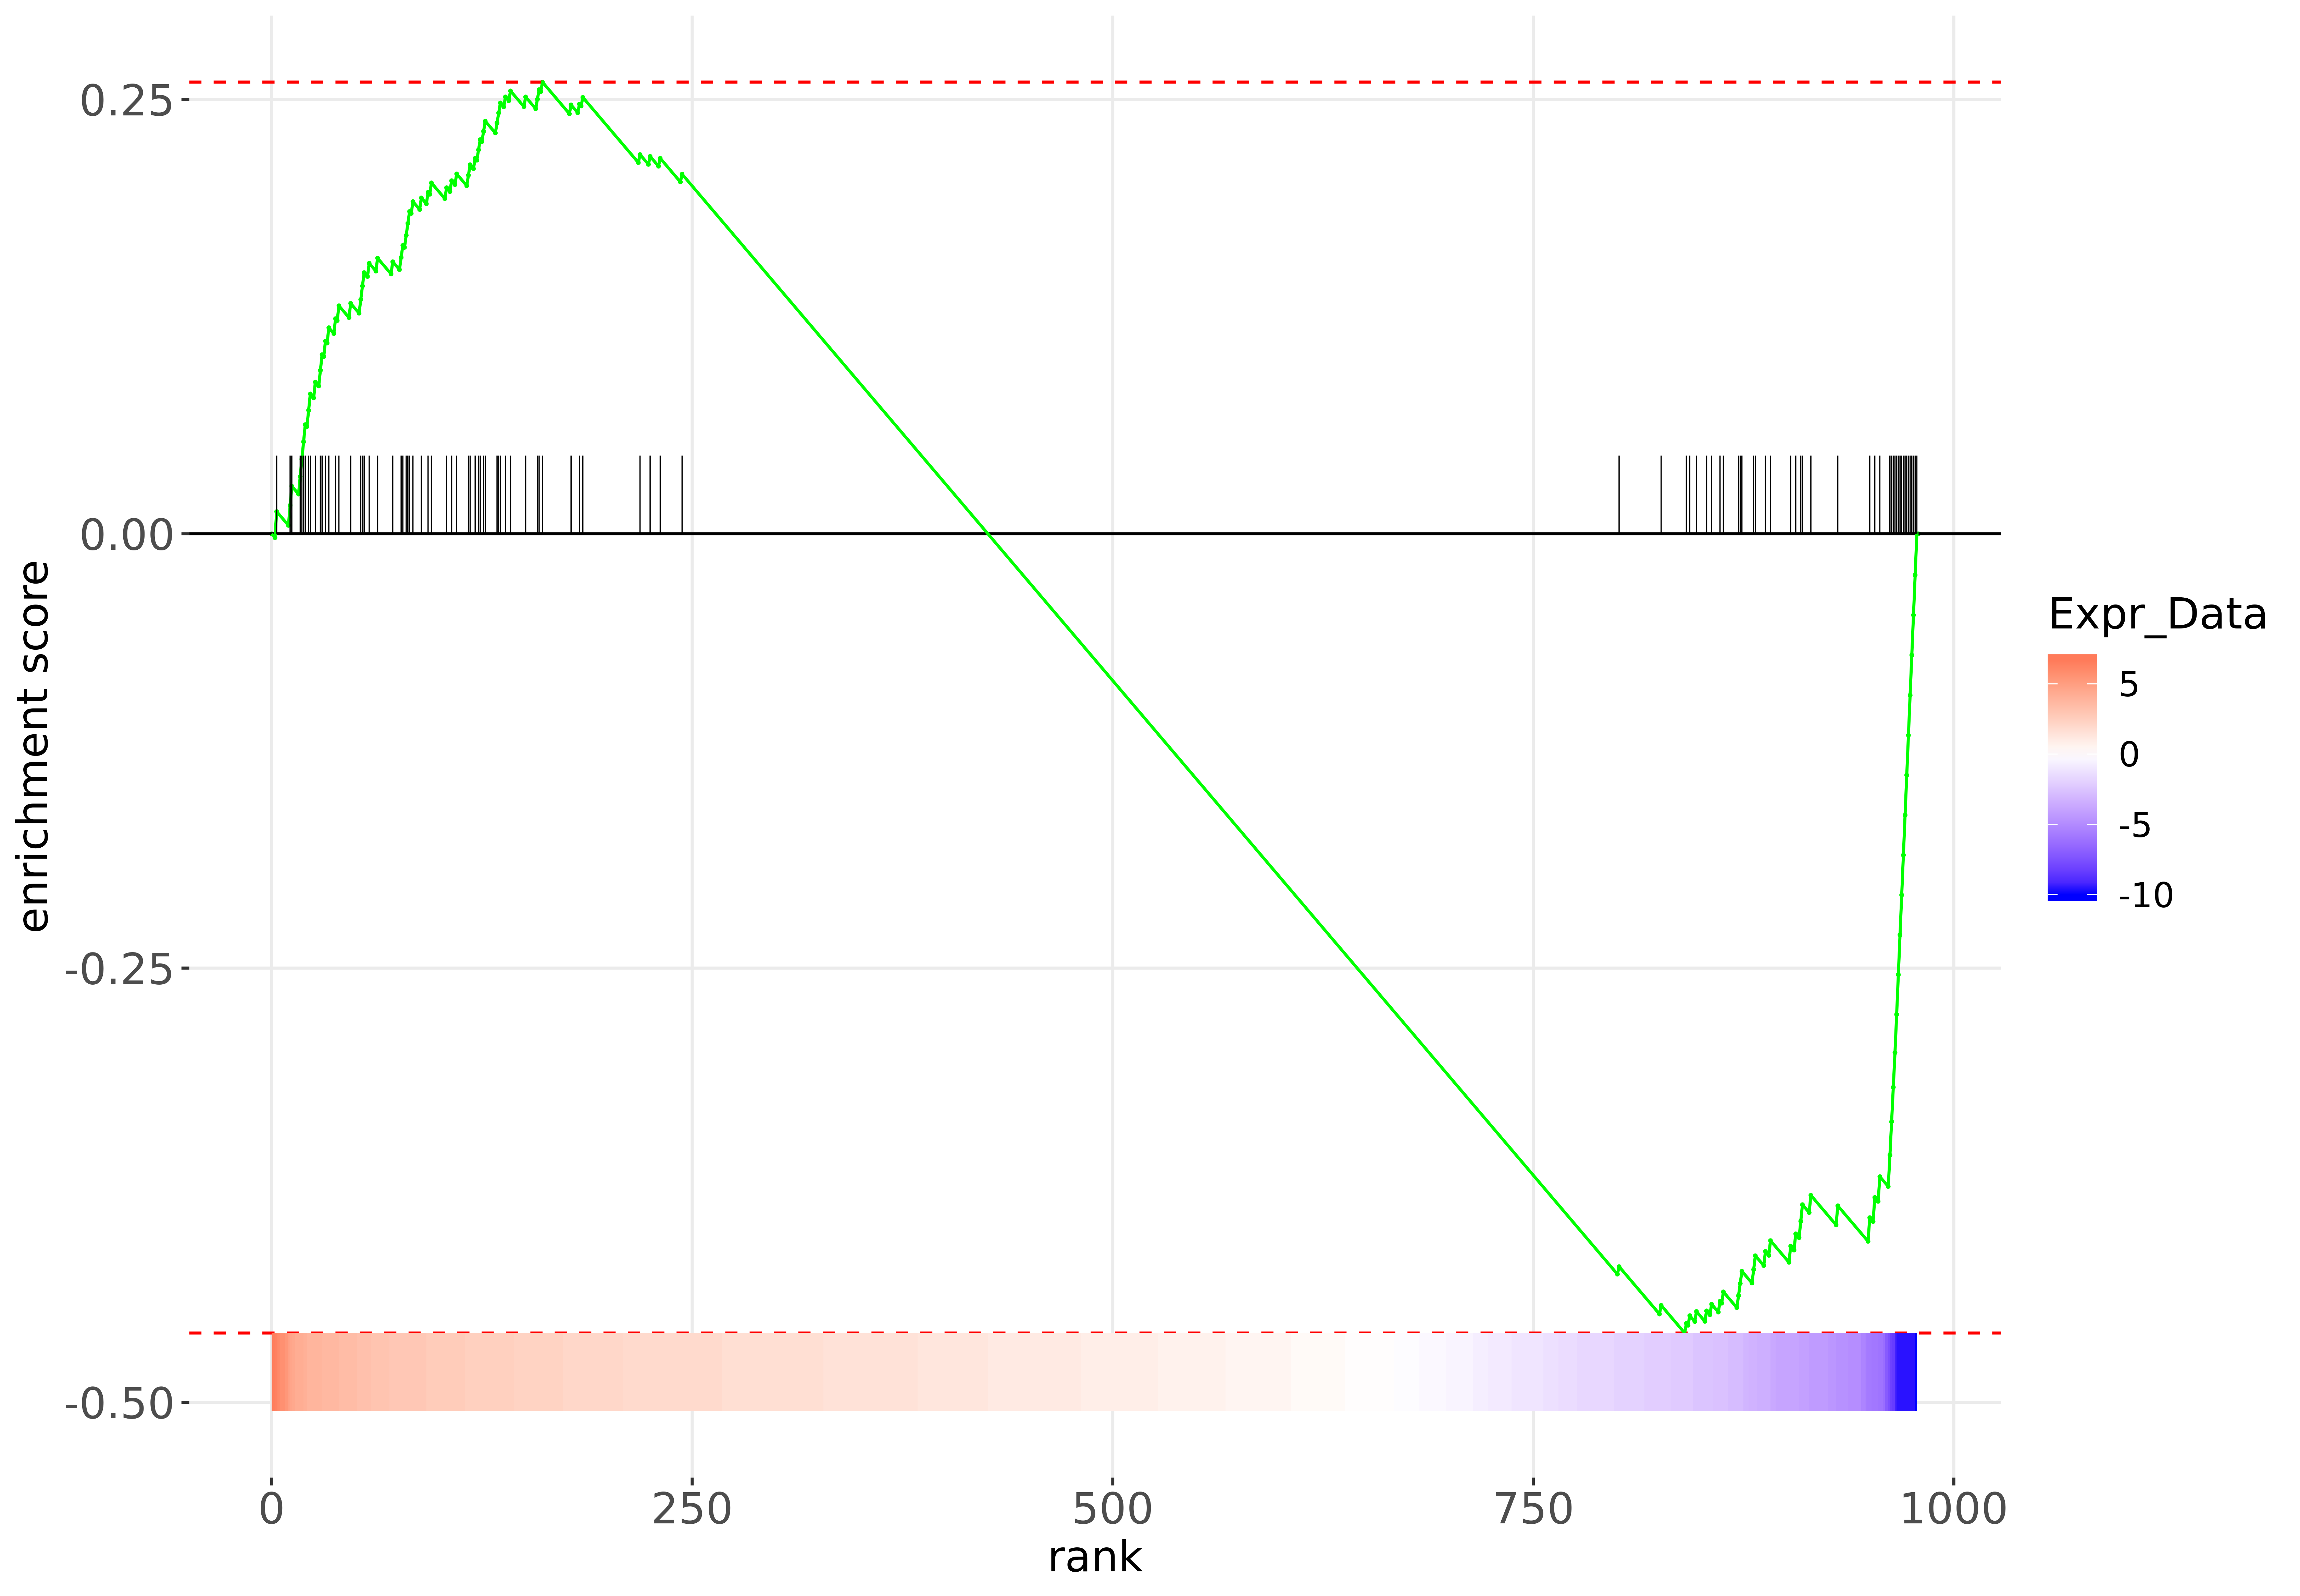

In [ ]:
# {r GSEA plot, out.width="910px"}
apiUrl <- "http://www.ilincs.org/api/ilincsR/plotGSEA"
req <- POST(apiUrl, body = list(signatureId = ilincs_signatureId,genes = top100signature$ID_geneid, output="png"), encode = "json")

gseaPlotPng <- httr::content(req)$fileName
gseaPlotUrl <- paste("http://www.ilincs.org/tmp/",gseaPlotPng,".png",sep="")
display_png(file = url(gseaPlotUrl,"rb"), width = 900)

## Signature as a list of up and down genes

In [ ]:
apiUrl="http://www.ilincs.org/api/ilincsR/findConcordancesSC"

topUpRegulatedGenes <- list(genesUp=top100signature$Name_GeneSymbol[top100signature$Value_LogDiffExp > 0])
topDownregulatedGenes <- list(genesDown=top100signature$Name_GeneSymbol[top100signature$Value_LogDiffExp < 0])

req <- POST("http://www.ilincs.org/api/ilincsR/findConcordancesSC", body = list(mode="UpDn",metadata=TRUE,signatureProfile = c(topUpRegulatedGenes, topDownregulatedGenes)),encode = "json")

ilincsUpDnConnectedSignatures <- data.table::rbindlist(httr::content(req)$concordanceTable, use.names = TRUE, fill = TRUE)
head(ilincsUpDnConnectedSignatures)

signatureID,similarity,pValue,nGenes,compound,lincsPertID,GeneTargets,concentration,cellLine,time,_row
<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
LINCSCP_100,0.9040515,5.918141e-38,100,Diclofenac,LSM-2160,PTGS1|PTGS2,10uM,A375,6h,LINCSCP_100
LINCSCP_99,0.8410478,6.743174e-28,100,YM90709,LSM-2128,IL5RA,10uM,A375,6h,LINCSCP_99
LINCSCP_160,0.8101921,1.820949e-24,100,Tubocurarine,LSM-4245,CHRNA1|CHRNA2|CHRNB1|CHRND|CHRNE|CHRNG|HTR3A,10uM,A375,6h,LINCSCP_160
LINCSCP_176580,0.7854960,3.836512e-22,100,Amidate,LSM-1640,GABRA1|GABRA2|GABRA3|GABRA4|GABRA5|GABRA6|GABRB1|GABRB2|GABRB3|GABRD|GABRE|GABRG1|GABRG2|GABRG3|GABRP|GABRQ,10uM,A375,6h,LINCSCP_176580
LINCSCP_176698,0.7817987,8.044258e-22,100,TOCRIS-0930,LSM-2999,ADRB3,10uM,A375,6h,LINCSCP_176698
LINCSCP_1829,0.7795406,1.255487e-21,100,Tozasertib,LSM-1021,ABL1|AURKA|AURKB|AURKC|BCR|FLT3|JAK2,10uM,A375,6h,LINCSCP_1829


## Group analysis of top 20 most connected signatures with signature of interest

In [ ]:
signatureGroup <-ilincsUpDnConnectedSignatures$signatureID[1:20]
apiUrl<-"http://www.ilincs.org/api/ilincsR/GroupLincsAnalysis"
req<-POST(apiUrl, body = list(idList = signatureGroup,noOfGenes = 50), encode = "json")                   
groupAnalysisSessionID <- httr::content(req)$data[[2]]
groupAnalysisSessionID

[1] "Sat_Feb__06_30_03_5_3739221"

### Signature group heatmap on iLINCS


In [ ]:
heatmap_url<-paste("http://www.ilincs.org/apps/heatmap/?sessionID=",groupAnalysisSessionID,"&property=signatureID",sep = "")

link <- paste0("[Signature group heatmap on iLINCS](",heatmap_url,")")
display_markdown(link)

# browseURL(heatmap_url)  ##uncoment to launch the browser
# include_url(heatmap_url, height = "900px")  ##uncomment to embed in iframe

[Signature group heatmap on iLINCS](http://www.ilincs.org/apps/heatmap/?sessionID=Sat_Feb__06_30_03_5_3739221&property=signatureID)

### Signature group PCA and tSNE app on iLINCS


In [ ]:
pca_url<-paste("http://www.ilincs.org/apps/pca/?sessionID=",groupAnalysisSessionID,"&property=signatureID",sep = "")

link <- paste0("[Signature group PCA and tSNE app on iLINCS](",pca_url,")")
display_markdown(link)

# browseURL(pca_url)  ##uncoment to launch the browser
# include_url(pca_url, height = "900px")  ##uncomment to embed in iframe

[Signature group PCA and tSNE app on iLINCS](http://www.ilincs.org/apps/pca/?sessionID=Sat_Feb__06_30_03_5_3739221&property=signatureID)

### Load r ExpressionSet from the signature analysis

In [ ]:
load(url(paste("http://www.ilincs.org/tmp/filteredeset_",groupAnalysisSessionID,".RData",sep="")),verbose=T)
eset<-get(paste("filteredeset_",groupAnalysisSessionID,sep=""))
eset

Loading objects:
  filteredeset_Sat_Feb__06_30_03_5_3739221


ExpressionSet (storageMode: lockedEnvironment)
assayData: 453 features, 20 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: LINCSCP_100 LINCSCP_99 ... LINCSCP_176754 (20 total)
  varLabels: signatureID compound ... treatment (6 total)
  varMetadata: labelDescription
featureData
  featureNames: 5993::RFX5::regulatory factor X5 9134::CCNE2::cyclin E2
    ... 1277::COL1A1::collagen type I alpha 1 chain (453 total)
  fvarLabels: ID_geneid Name_GeneSymbol DESCRIPTION
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

### Download gct from the signature analysis

In [ ]:
download.file(paste("http://www.ilincs.org/tmp/filteredeset_",groupAnalysisSessionID,".gct",sep=""),destfile="sigs.gct")
sigs <- readLines(con <- file("sigs.gct"))
head(sigs,n=10)

[1] "#1.3"                                                                                                                                                                                                                                                                                                                                        
 [2] "453\t20\t3\t6"                                                                                                                                                                                                                                                                                                                               
 [3] "id\tID_geneid\tName_GeneSymbol\tDESCRIPTION\tLINCSCP_100\tLINCSCP_99\tLINCSCP_160\tLINCSCP_176580\tLINCSCP_176698\tLINCSCP_1829\tLINCSCP_65\tLINCSCP_176748\tLINCSCP_178725\tLINCSCP_176625\tLINCSCP_176560\tLINCSCP_124\tLINCSCP_138\tLINCSCP_176578\tLINCSCP_109\tLINCSCP_2105\tLINCSCP_176623\tLINCSCP_2321\tLINCSCP_2160\tLINCSCP_176754"
 [4] "signatureID\tna\tna\tna\tLINCSCP_100\tLINCSCP_99\tLINCSCP_160\tLINCSCP_176580\tLINCSCP_176698\tLINCSCP_1829\tLINCSCP_65\tLINCSCP_176748\tLINCSCP_178725\tLINCSCP_176625\tLINCSCP_176560\tLINCSCP_124\tLINCSCP_138\tLINCSCP_176578\tLINCSCP_109\tLINCSCP_2105\tLINCSCP_176623\tLINCSCP_2321\tLINCSCP_2160\tLINCSCP_176754"                    
 [5] "compound\tna\tna\tna\tDiclofenac\tYM90709\tTubocurarine\tAmidate\tTOCRIS-0930\tTozasertib\tChlorthalidone\tTrazodone\tClotrimazole\tPiperidolate\tOxfendazole\tErythromycin Estolate\tCilostazol\tVenlafaxine\tRS-39604\tPK04_181029\tDexamethasone Acetate\tChenodiol\tAC1M5YQH\tStaurosporine Aglycon"                                     
 [6] "concentration\tna\tna\tna\t10uM\t10uM\t10uM\t10uM\t10uM\t10uM\t10uM\t10uM\t10uM\t10uM\t10uM\t10uM\t10uM\t10uM\t10uM\t10uM\t10uM\t10uM\t10uM\t10uM"                                                                                                                                                                                           
 [7] "cellLine\tna\tna\tna\tA375\tA375\tA375\tA375\tA375\tA375\tA375\tA375\tA375\tA375\tA375\tA375\tA375\tA375\tA375\tA375\tA375\tA375\tA375\tA375"                                                                                                                                                                                                
 [8] "time\tna\tna\tna\t6h\t6h\t6h\t6h\t6h\t6h\t6h\t6h\t6h\t6h\t6h\t6h\t6h\t6h\t6h\t6h\t6h\t6h\t6h\t6h"                                                                                                                                                                                                                                            
 [9] "treatment\tna\tna\tna\tDiclofenac\tYM90709\tTubocurarine\tAmidate\tTOCRIS-0930\tTozasertib\tChlorthalidone\tTrazodone\tClotrimazole\tPiperidolate\tOxfendazole\tErythromycin Estolate\tCilostazol\tVenlafaxine\tRS-39604\tPK04_181029\tDexamethasone Acetate\tChenodiol\tAC1M5YQH\tStaurosporine Aglycon"                                    
[10] "5993::RFX5::regulatory factor X5\t5993\tRFX5\tregulatory factor X5\t-10\t-4.47623\t-9.54631\t1.40607\t1.01019\t-4.40532\t1.54067\t-4.43403\t1.94129\t1.75126\t-2.14805\t-4.2685\t-8.68012\t2.87324\t2.45352\t-7.18714\t1.20953\t-5.25076\t-3.35107\t-3.80186"

## Find connected signatures based on user submitted full signature

##### Creating a file to upload from previouslsy downloaded signature file

In [ ]:
write.table(signatureData,file="sigFile.tsv",sep="\t",row.names=F,col.names = T,quote=F)
system(paste("head sigFile.tsv"))

### Upload the file

In [ ]:
apiUrl<-"http://www.ilincs.org/api/SignatureMeta/upload"
sigFile <- "sigFile.tsv"
req <- POST(apiUrl, body=list(file=upload_file("sigFile.tsv")))
signatureFile <- httr::content(req)$status$fileName[[1]]
signatureFile

[1] "processedSig_Sat_Feb_5_06_33_04_2022_6415712.xls"

### Find connected signatures

In [ ]:
apiUrl <- "http://www.ilincs.org/api/ilincsR/findConcordances"
req <- (POST(apiUrl, body = list(file=signatureFile, lib="LIB_5"), encode = "form"))
output <- data.table::rbindlist(httr::content(req)$concordanceTable, use.names = TRUE, fill = TRUE)
head(output)

similarity,pValue,nGenes,compound,lincsPertID,GeneTargets,concentration,time,_row,signatureid,cellline
<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.0000000,0.000000e+00,978,Diclofenac,LSM-2160,PTGS1|PTGS2,10uM,6h,LINCSCP_100,LINCSCP_100,A375
0.7716616,5.196493e-194,978,Cilostazol,LSM-3491,PDE3A,10uM,6h,LINCSCP_138,LINCSCP_138,A375
0.7584963,1.053554e-183,978,RS-39604,LSM-2461,HTR4,10uM,6h,LINCSCP_109,LINCSCP_109,A375
0.7343051,2.153252e-166,978,Amidate,LSM-1640,GABRA1|GABRA2|GABRA3|GABRA4|GABRA5|GABRA6|GABRB1|GABRB2|GABRB3|GABRD|GABRE|GABRG1|GABRG2|GABRG3|GABRP|GABRQ,10uM,6h,LINCSCP_176580,LINCSCP_176580,A375
0.7286845,1.216400e-162,978,R-N-Propylnorapomorphine,LSM-2281,DRD1|DRD2,10uM,6h,LINCSCP_102,LINCSCP_102,A375
0.7170716,3.515517e-155,978,Erythromycin Estolate,LSM-2876,ABCB1|ALB|CYP3A4|CYP51A1|KCNH2|MLNR|SLC47A1,10uM,6h,LINCSCP_124,LINCSCP_124,A375


## Find connected compound perturbations

In [ ]:
apiUrl <- paste("http://www.ilincs.org/api/ilincsR/signatureEnrichment?sigFile=",signatureFile,"&library=LIB_5&metadata=TRUE",sep="")
req <- GET(apiUrl)
json <- httr::content(req, as = "text")
iLincsConnectedCompoundPerturbations <- fromJSON(json)$enrichment
head(iLincsConnectedCompoundPerturbations)

,categoryName,compound,lincsPertID,Targets,zScore,pValue,FDR,nSignature,connDirection
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,BRD-A50796384,PK04_181029,LSM-4443,NA,16.65763,1.331807e-62,4.088380e-58,2,+
2,BRD-K66896231,Ipidacrine,LSM-37163,ACHE,14.69796,3.321418e-49,5.098045e-45,3,+
3,BRD-K88679075,Methandriol,LSM-5941,NA,14.17252,6.777678e-46,6.935372e-42,7,+
4,BRD-K56855930,CHEMBL1514777,LSM-3267,NA,14.03157,4.995539e-45,3.833826e-41,3,+
5,BRD-A49447682,Desoxymetasone,LSM-1602,NR3C1,13.48046,1.019178e-41,6.257345e-38,12,+
6,BRD-K88304388,Dextrorphan,LSM-36603,"OPRM1, OPRK1, OPRD1",13.19368,4.770330e-40,2.440660e-36,5,+


## Get connected genetic perturbations

In [ ]:
apiUrl <- paste("http://www.ilincs.org/api/ilincsR/signatureEnrichment?sigFile=",signatureFile,"&library=LIB_6",sep="")
req <- GET(apiUrl)
json <- httr::content(req, as = "text")
iLincsConnectedGeneticPerturbations <- fromJSON(json)$enrichment
head(iLincsConnectedGeneticPerturbations)

,categoryName,compound,zScore,pValue,FDR,nSignature,connDirection,pathways
,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,TBP,NA,14.684756,4.036192e-49,3.509873e-45,8,+,Basal transcription factors | Huntington disease | Human papillomavirus infection | Human T-cell leukemia virus 1 infection | Viral carcinogenesis
2,NR2C2,NA,9.257959,1.041889e-20,4.530135e-17,8,+,
3,TCEB3,NA,8.685816,1.880162e-18,5.449963e-15,9,+,
4,DYRK1A,NA,8.376358,2.729545e-17,5.934031e-14,10,+,
5,ERBB3,NA,7.355370,9.519917e-14,1.655704e-10,25,+,MAPK signaling pathway | ErbB signaling pathway | Calcium signaling pathway | PI3K-Akt signaling pathway | Proteoglycans in cancer | MicroRNAs in cancer
6,MAST4,NA,7.265283,1.861294e-13,2.697635e-10,19,+,


## Retriving Signature Metadata

In [ ]:
apiUrl <- paste("http://www.ilincs.org/api/SignatureMeta/",ilincs_signatureId,sep="")
req <- GET(apiUrl)
ilincsJSON<-httr::content(req,type="text")
prettify(ilincsJSON)

No encoding supplied: defaulting to UTF-8.



{
    "antibodytarget": null,
    "cellline": "A375",
    "tissue": "skin",
    "cid": null,
    "compound": "Diclofenac",
    "concentration": "10uM",
    "concordancetable": "concordanceLib5",
    "datasetid": null,
    "factor": null,
    "level1": null,
    "level2": null,
    "libraryid": "LIB_5",
    "lincspertid": "LSM-2160",
    "nCtrSamples": null,
    "nTrtSamples": null,
    "peaktype": null,
    "platform": "L1000",
    "signatureid": "LINCSCP_100",
    "lincsSigID": "CPC004_A375_6H:BRD-K08252256-236-17-1:10",
    "organism": null,
    "clueIoCompound": "diclofenac",
    "integratedMoas": "Cyclooxygenase inhibitor",
    "GeneTargets": "PTGS1|PTGS2",
    "time": "6h",
    "treatment": "Diclofenac",
    "perturbagenID": "BRD-K08252256",
    "stitchID": "CID3033",
    "pubChemID": "3033",
    "is_exemplar": 1,
    "pert_type": "trt_cp"
}
 

In [ ]:
ilincsSigMetaData<-fromJSON(ilincsJSON)
head(ilincsSigMetaData)

$antibodytarget
NULL

$cellline
[1] "A375"

$tissue
[1] "skin"

$cid
NULL

$compound
[1] "Diclofenac"

$concentration
[1] "10uM"

### List of LINCS Datasets

In [ ]:
apiUrl <- "http://www.ilincs.org/api/PublicDatasets/getDatasets?lincs=true"
req <- GET(apiUrl)
json <- httr::content(req, as = "text")
lincs_datasets <- fromJSON(json)
lincsDatasets <- data.frame(lincs_datasets$data)
lincsDatasets[c("experiment","assay","dataType")]

,experiment,assay,dataType
,<chr>,<chr>,<chr>
1,EDS-1013,RPPA,Proteomics
2,EDS-1014,RNA-seq,Gene Expression
3,LDG-1188,L1000,Gene Expression
4,LDG-1193,P100,Proteomics
5,LDG-1228,P100,Proteomics
6,LDG-1230,GCP,Proteomics
7,LDG-1231,RNA-seq,Gene Expression
8,LDG-1233,RNA-seq,Gene Expression
9,LDG-1255,P100,Proteomics


### Dataset metadata

**Example:** EDS-1014  

In [ ]:
experiment <- "EDS-1014"

apiUrl <- paste("http://www.ilincs.org/api/PublicDatasets/",experiment,sep="")
req <- GET(apiUrl)
json <- httr::content(req, as = "text")
datasetMetaData <- fromJSON(json)
datasetMetaData

$platform
[1] "GPL10999syn2347004"

$description
[1] "54 mRNA-seq samples from baseline, unperturbed breast cancer cell lines were profiled using Illumina Genome Analyzer IIx to identify patterns of gene expression associated with subtype and response to therapeutic compounds. Data were generated by Microenvironment Perturbagen (MEP) LINCS Center at Oregon Health and Science University."

$summary
NULL

$geolink
[1] "https://www.synapse.org/#!Synapse:syn2347004"

$lincsDsgc
[1] "ohsu"

$publink
[1] "http://www.ncbi.nlm.nih.gov/pubmed/24176112"

$pubmeddescription
[1] "Daemen A, Griffith OL, Heiser LM, Wang NJ et al. Modeling precision treatment of breast cancer. Genome Biol 2013;14(10):R110."

$experiment
[1] "EDS-1014"

$assay
[1] "RNA-seq"

$dataFormat
[1] "MaxD"

$sampleType
[1] "cell line"

$dataType
[1] "Gene Expression"

$organism
[1] "human"

$portal
[1] "LINCS"

$SourceID
[1] "EDS-1014"

$nsamples
[1] 54

In [ ]:
heatmap_exp_url <- paste0("(http://www.ilincs.org/apps/heatmap/?data_set=", experiment)

link <- paste0("[Heatmap for dataset ",experiment," on iLINCS](",heatmap_exp_url,")")
display_markdown(link)

[Heatmap for dataset EDS-1014 on iLINCS]((http://www.ilincs.org/apps/heatmap/?data_set=EDS-1014)

In [ ]:
pca_tsne_exp_url <- paste0("(http://www.ilincs.org/apps/pca/?data_set=", experiment)

link <- paste0("[PCA and tSNE for dataset ",experiment," on iLINCS](",pca_tsne_exp_url,")")
display_markdown(link)

[PCA and tSNE for dataset EDS-1014 on iLINCS]((http://www.ilincs.org/apps/pca/?data_set=EDS-1014)

### Dataset sample metadata

In [ ]:
apiUrl <- paste("http://www.ilincs.org/api/ilincsR/getSamples?id=",experiment,sep="")
req <- GET(apiUrl)
json <- httr::content(req, as = "text")
sampleMeta <- fromJSON(json)
sampleMetaData <- data.frame(sampleMeta$data$rows)
head(sampleMetaData)

,MeasurementName,geo_accession,cell,cell_type,subtype,subtype_4class,subtype_charact,ER,PGR,ERBB2,EGFR,CK5,CK8.18,CK19,CK14
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,EDS-1014_184A1,GSM1172844,184A1,breast cancer,Non-malignant,Non-malignant,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,EDS-1014_184B5,GSM1172845,184B5,breast cancer,Non-malignant,Non-malignant,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,EDS-1014_21MT1,GSM1172846,21MT1,breast cancer,Basal,ERBB2AMP,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,EDS-1014_21MT2,GSM1172847,21MT2,breast cancer,Basal,ERBB2AMP,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,EDS-1014_21NT,GSM1172848,21NT,breast cancer,Basal,ERBB2AMP,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6,EDS-1014_21PT,GSM1172849,21PT,breast cancer,Basal,ERBB2AMP,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


## Creating signature using iLINCS

In [ ]:
experiment_url <- paste0("http://www.ilincs.org/ilincs/dataset/", experiment, "/createSignature")

link <- paste0("[Create signature from dataset ",experiment," on iLINCS](",experiment_url,")")
display_markdown(link)

[Create signature from dataset EDS-1014 on iLINCS](http://www.ilincs.org/ilincs/dataset/EDS-1014/createSignature)

## Creating signature using iLINCS API

In [ ]:
property <- "ER"
level1 <- "ER:+"
level2 <- "ER:-"
apiUrl <- "http://www.ilincs.org/api/ilincsR/LincsDataAnalysis"
req <- POST(apiUrl, body = list(exp = paste(experiment),prop = property,filterchk=paste(level1,level2,sep = ",,,"),includeORexclude=1), encode = "json")
createdSignaturesSessionID <- httr::content(req)$sessionID
createdSignaturesSessionID

[1] "Sat_Feb_5_06_35_27_2022_6941516"

## Top 100 genes in created signature

In [ ]:
l <- lapply(httr::content(req)$geneData, function(x) unlist(x))
ilincs_result <- data.frame(t(sapply(l,c)))
top100signatureData <- ilincs_result[1:100,c("Name_GeneSymbol","Value_LogDiffExp","Significance_pvalue")]
head(top100signatureData)

,Name_GeneSymbol,Value_LogDiffExp,Significance_pvalue
,<chr>,<chr>,<chr>
1,ESR1,5.04612368895955,9.77717053245281e-11
2,LONRF2,3.5886776758536,1.76926493709e-10
3,C5AR2,4.67488171523746,5.50651622231375e-10
4,HLA-DQA2,2.19208545626605,8.53024554068061e-08
5,ACER1,2.73772191502951,2.87510651441037e-07
6,GREB1,4.60204070527715,3.7267975079554e-07



### Heatmap of data used in signature creation


### Signature group heatmap on iLINCS

In [ ]:
heatmap_url2<-paste("http://www.ilincs.org/apps/heatmap/?sessionID=",createdSignaturesSessionID,"&property=",property,"&geneCount=100",sep = "")

link <- paste0("[Signature group heatmap on iLINCS](",heatmap_url2,")")
display_markdown(link)

# browseURL(heatmap_url2)  ##uncomment to launch in a browser
# include_url(heatmap_url2, height = "900px")  ##uncomment to embed in an iframe

[Signature group heatmap on iLINCS](http://www.ilincs.org/apps/heatmap/?sessionID=Sat_Feb_5_06_35_27_2022_6941516&property=ER&geneCount=100)